In [1]:
import os
import matplotlib.pyplot as plt
import numpy as np
from sklearn.linear_model import Lasso, LassoCV, LogisticRegression, LogisticRegressionCV, LinearRegression,\
    ElasticNet, ElasticNetCV, MultiTaskElasticNet, MultiTaskElasticNetCV
from sklearn.ensemble import RandomForestRegressor, RandomForestClassifier
from sklearn.preprocessing import PolynomialFeatures
from sklearn.model_selection import train_test_split
import mliv.dgps_mediated as dgps
from mliv.ensemble import EnsembleIV, EnsembleIVStar
from mliv.rkhs import ApproxRKHSIVCV
from mliv.shape import LipschitzShapeIV, ShapeIV
from mliv.linear import OptimisticHedgeVsOptimisticHedge, StochasticOptimisticHedgeVsOptimisticHedge
from mliv.linear import L2OptimisticHedgeVsOGD, L2ProxGradient
from sklearn.pipeline import Pipeline

from pathlib import Path
import numpy as np
import torch
import torch.nn as nn
from sklearn.cluster import KMeans
#from mliv.neuralnet.deepiv_fit import deep_iv_fit
from mliv.neuralnet.rbflayer import gaussian, inverse_multiquadric
from mliv.neuralnet import AGMM, KernelLayerMMDGMM, CentroidMMDGMM, KernelLossAGMM, MMDGMM
from mliv.tsls import tsls, regtsls

p = 0.1  # dropout prob of dropout layers throughout notebook
n_hidden = 100  # width of hidden layers throughout notebook

# For any method that use a projection of z into features g(z)
g_features = 100

# The kernel function
kernel_fn = gaussian
# kernel_fn = inverse_multiquadric

# Training params
learner_lr = 1e-4
adversary_lr = 1e-4
learner_l2 = 1e-3
adversary_l2 = 1e-4
adversary_norm_reg = 1e-3
n_epochs = 300
bs = 100
sigma = 2.0 / g_features
n_centers = 100
device = torch.cuda.current_device() if torch.cuda.is_available() else None


In [2]:
from dml_mediated import DML_mediated

In [3]:
fn_number = 0
tau_fn = dgps.get_tau_fn(fn_number)
tauinv_fn = dgps.get_tauinv_fn(fn_number)
W, Z, X, M, D, Y, tau_fn = dgps.get_data(2000, tau_fn)

V = np.random.rand(Y.shape[0])
V = V.reshape(-1, 1)

print(np.column_stack((W,X,Z)).shape)
ind = np.where(D==0)[0]
W0 = W[ind]
X0 = X[ind,:]
W0_test = np.zeros((1000, 1+X.shape[1]))
W0_test += np.median(np.column_stack((X0,W0)), axis=0, keepdims=True)
W0_test[:, 2] = np.linspace(np.percentile(
            W0[:, 0], 5), np.percentile(W0[:, 0], 95), 1000)

# True parameters
b_yd = 2.0; b_ym = 1.0; b_yx = np.array([[-1.0],[-1.0]]); b_yu = -1.0; b_yw = 2.0; b_y0 = 2.0
b_wx = np.array([[0.2],[0.2]]); b_wu = -0.6; b_w0 = 0.3
b_md = -0.3; b_mx = np.array([[-0.5],[-0.5]]); b_mu = 0.4; b_m0 = 0.0
    
gamma_1w = (b_yw*b_wu + b_yu)/b_wu
gamma_1x = b_yw*b_wx + b_yx - gamma_1w*b_wx
gamma_1m = b_ym
gamma_10 = b_y0 + b_yd + b_yw*b_w0 - gamma_1w*b_w0

gamma_0w = (gamma_1m*b_mu + gamma_1w*b_wu)/b_wu
gamma_0x = gamma_1m*b_mx + gamma_1w*b_wx + gamma_1x - gamma_0w*b_wx
gamma_00 = gamma_10 + gamma_1m*b_m0 + gamma_1w*b_w0 - gamma_0w*b_w0

    # True nuisance function
expected_te = gamma_00 + tauinv_fn(W0_test)@np.row_stack((gamma_0x, gamma_0w))


(2000, 4)


In [4]:
rkhs_model = ApproxRKHSIVCV(kernel_approx='nystrom', n_components=100,
                           kernel='rbf', gamma=.1, delta_scale='auto',
                           delta_exp=.4, alpha_scales=np.geomspace(1, 10000, 10), cv=5)

def _get_learner(n_t):
    return nn.Sequential(nn.Dropout(p=p), nn.Linear(n_t, n_hidden), nn.LeakyReLU(),
                         nn.Dropout(p=p), nn.Linear(n_hidden, 1))


def _get_adversary(n_z):
    return nn.Sequential(nn.Dropout(p=p), nn.Linear(n_z, n_hidden), nn.LeakyReLU(),
                         nn.Dropout(p=p), nn.Linear(n_hidden, 1))


def _get_adversary_g(n_z):
    return nn.Sequential(nn.Dropout(p=p), nn.Linear(n_z, n_hidden), nn.LeakyReLU(),
                         nn.Dropout(p=p), nn.Linear(n_hidden, g_features), nn.ReLU())


agmm_1 = AGMM(_get_learner(4),_get_adversary(4))
agmm_2 = AGMM(_get_learner(3),_get_adversary(3))

In [5]:
dml_agmm = DML_mediated(Y, D, M, W, Z, X,
                        model1 = agmm_1,
                        model2 = agmm_2,
                        modelq1 = agmm_2,
                        modelq2 = agmm_1,
                        n_folds=5, n_rep=1,
                        CHIM = False,
                        nn_1 = True,
                        nn_2 = True,
                        nn_q1 = True,
                        nn_q2 = True,
                        fitargs1 = {'n_epochs': 300, 'bs': 100, 'learner_lr': 1e-4, 'adversary_lr': 1e-4, 'learner_l2': 1e-3, 'adversary_l2': 1e-4, 'adversary_norm_reg' : 1e-3},
                        fitargs2 = {'n_epochs': 300, 'bs': 100, 'learner_lr': 1e-4, 'adversary_lr': 1e-4, 'learner_l2': 1e-3, 'adversary_l2': 1e-4},
                        fitargsq1 = {'n_epochs': 300, 'bs': 100, 'learner_lr': 1e-4, 'adversary_lr': 1e-4, 'learner_l2': 1e-3, 'adversary_l2': 1e-4},
                        fitargsq2 = {'n_epochs': 300, 'bs': 100, 'learner_lr': 1e-4, 'adversary_lr': 1e-4, 'learner_l2': 1e-3, 'adversary_l2': 1e-4},
                        opts = {'lin_degree': 1, 'burnin': 200})


In [6]:
print(dml_agmm.dml())

Rep: 1


100%|██████████| 5/5 [09:49<00:00, 117.93s/it]

(3.848386621492983, 35.197110232618364, array([3.58837869, 4.10839455]))


In [8]:
_ , gamma_0 = dml_agmm._nnpivfit_outcome(Y=Y, D=D, M=M, W=W, X=X, Z=Z)
gamma0_hat = gamma_0.predict(torch.Tensor(W0_test))


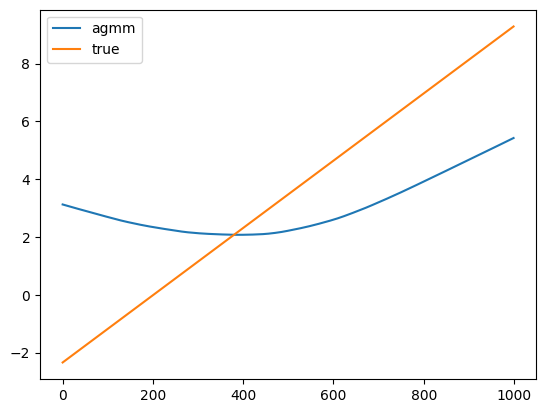

In [10]:

plt.show()
plt.plot(gamma0_hat)
plt.plot(expected_te)
plt.legend(['agmm', 'true'])

In [13]:

print(np.mean(gamma_0.predict(torch.cat((torch.Tensor(X), torch.Tensor(W)),1))))
#In principle this should be the same as the 'OR' estimator


3.2100952


In [21]:
percentiles = np.arange(5, 100, 5)
v_values = np.percentile(V, percentiles)

agmm_1 = AGMM(_get_learner(5),_get_adversary(5))
agmm_2 = AGMM(_get_learner(4),_get_adversary(4))

dml_agmm_ = DML_mediated(Y, D, M, W, Z, X, V=V,
                        v_values=v_values,
                        loc_kernel = 'gau',
                        bw_loc = 'scott',
                        model1 = agmm_1,
                        model2 = agmm_2,
                        modelq1 = agmm_2,
                        modelq2 = agmm_1,
                        n_folds=5, n_rep=1,
                        CHIM = False,
                        nn_1 = True,
                        nn_2 = True,
                        nn_q1 = True,
                        nn_q2 = True,
                        fitargs1 = {'n_epochs': 300, 'bs': 100, 'learner_lr': 1e-4, 'adversary_lr': 1e-4, 'learner_l2': 1e-3, 'adversary_l2': 1e-4, 'adversary_norm_reg' : 1e-3},
                        fitargs2 = {'n_epochs': 300, 'bs': 100, 'learner_lr': 1e-4, 'adversary_lr': 1e-4, 'learner_l2': 1e-3, 'adversary_l2': 1e-4},
                        fitargsq1 = {'n_epochs': 300, 'bs': 100, 'learner_lr': 1e-4, 'adversary_lr': 1e-4, 'learner_l2': 1e-3, 'adversary_l2': 1e-4},
                        fitargsq2 = {'n_epochs': 300, 'bs': 100, 'learner_lr': 1e-4, 'adversary_lr': 1e-4, 'learner_l2': 1e-3, 'adversary_l2': 1e-4},
                        opts = {'lin_degree': 1, 'burnin': 200})

theta, vart, ci = dml_agmm_.dml()

print(theta)
print(np.mean(theta, axis=0))
print(vart)
print(ci)


Rep: 1


100%|██████████| 5/5 [07:00<00:00, 84.14s/it] 

[3.85853267 3.72631538 3.78854422 3.9891294  4.13912183 4.16872982
 4.11109184 4.06284539 4.00850335 3.91039658 3.80788695 3.73151272
 3.68182987 3.65254779 3.73694899 3.88791427 3.89598448 3.75313531
 3.5398697 ]
3.865833715081694
[251.04146553 205.30046742 190.87627753 211.60175043 228.20771981
 192.24444896 152.82247897 152.68628686 164.8112564  166.63261127
 157.33141281 193.68523109 252.78496061 253.38845736 211.87310597
 187.22688268 182.66101247 205.50386005 275.8478125 ]
[[3.16413889 4.55292645]
 [3.09836105 4.35426971]
 [3.1830513  4.39403714]
 [3.35161101 4.6266478 ]
 [3.47706044 4.80118322]
 [3.56107073 4.77638891]
 [3.56930717 4.65287652]
 [3.52130218 4.60438859]
 [3.44586863 4.57113807]
 [3.34466152 4.47613164]
 [3.25816786 4.35760603]
 [3.12158082 4.34144462]
 [2.98502896 4.37863078]
 [2.95491561 4.35017998]
 [3.09902195 4.37487603]
 [3.28823754 4.487591  ]
 [3.30366499 4.48830397]
 [3.12487    4.38140063]
 [2.81197616 4.26776324]]
